In [44]:
!pip install pandas

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


# process_data

In [45]:
import os
import json
import pandas as pd
from collections import defaultdict

# -------------------------------
# 配置路径
# -------------------------------
BASE_DIR = r"C:\Users\mhuiuyd\Desktop\RAW_TRACKS\National University of Singapore\Sandesh Sreepathy Upadhyaya - Football Dataset"
SEASON_FOLDERS = ["2425_FINAL", "2526_FINAL"]
OUTPUT_CSV = "player_summary_all_seasons.csv"

TARGET_JSONS = [
    "defense_all.json",
    "keeper_all.json",
    "misc_all.json",
    "passing_all.json",
    "passing_types_all.json",
    "possession_all.json",
    "summary_all.json"
]


# -------------------------------
# 工具函数
# -------------------------------
def safe_float(x):
    try:
        return float(x)
    except (ValueError, TypeError):
        return None


def clean_info_fields(info):
    """清洗 info.json 中异常的身高/体重字段"""
    def is_invalid_height(val: str):
        if not val:
            return False
        val = val.strip()
        # 出现日期、月份、年龄等明显异常
        if any(keyword in val for keyword in [
            "January", "February", "March", "April", "May", "June", "July",
            "August", "September", "October", "November", "December",
            "Age", "-", "/", "born", "Born"
        ]):
            return True
        # 太短或太长的非数值字符
        if len(val) > 10 and not any(ch.isdigit() for ch in val):
            return True
        return False

    def is_invalid_weight(val: str):
        if not val:
            return False
        val = val.strip()
        # 包含 Age 或非数字字符的
        if "Age" in val or any(m in val for m in ["year", "born", "(", ")"]):
            return True
        if len(val) > 8 and not any(ch.isdigit() for ch in val):
            return True
        return False

    if "height" in info and is_invalid_height(info["height"]):
        info["height"] = ""
    if "weight" in info and is_invalid_weight(info["weight"]):
        info["weight"] = ""
    return info


# -------------------------------
# 主处理逻辑
# -------------------------------
def process_player_folder_clean(player_folder):
    """处理单个球员文件夹，返回 { 'name':..., 'height':..., 平均值..., 'Pos_set':... }"""
    info_path = os.path.join(player_folder, "info.json")
    if not os.path.exists(info_path):
        return None

    try:
        with open(info_path, "r", encoding="utf-8") as f:
            info = json.load(f)
    except Exception:
        return None

    # 清洗异常 info
    info = clean_info_fields(info)

    player_name = info.get("name", None)
    if not player_name:
        return None

    numeric_max = {}  # 存储不同文件间的最大值
    match_num = 0
    pos_set = set()

    for file_name in TARGET_JSONS:
        file_path = os.path.join(player_folder, file_name)
        if not os.path.exists(file_path):
            continue

        candidate_match_num = 0
        file_sums = defaultdict(float)
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)
        except Exception:
            continue

        for item in data:
            min_val = safe_float(item.get("Min"))
            if min_val is None:
                continue
            candidate_match_num += 1

            for k, v in item.items():
                val = safe_float(v)
                if val is not None:
                    file_sums[k] += val

            pos_val = item.get("Pos", "")
            if pos_val and pos_val != "On matchday squad, but did not play":
                for p in pos_val.replace(" ", "").split(","):
                    if p:
                        pos_set.add(p)

        # 不同文件间取最大值
        for k, v in file_sums.items():
            if k in numeric_max:
                numeric_max[k] = max(numeric_max[k], v)
            else:
                numeric_max[k] = v

        match_num = max(match_num, candidate_match_num)

    numeric_max["Pos_set"] = ", ".join(sorted(pos_set))
    numeric_max["Match_num"] = match_num

    return {**info, **numeric_max}


def aggregate_all_players_clean():
    all_players = defaultdict(lambda: defaultdict(list))
    all_positions = defaultdict(set)
    base_info = {}

    for season in SEASON_FOLDERS:
        season_path = os.path.join(BASE_DIR, season)
        if not os.path.exists(season_path):
            print(f"⚠️ 跳过不存在的目录: {season_path}")
            continue

        for club in os.listdir(season_path):
            club_path = os.path.join(season_path, club)
            if not os.path.isdir(club_path):
                continue

            for player in os.listdir(club_path):
                player_folder = os.path.join(club_path, player)
                if not os.path.isdir(player_folder):
                    continue

                result = process_player_folder_clean(player_folder)
                if not result:
                    continue

                name = result.get("name")
                base_info[name] = {k: result[k] for k in ["name", "height", "weight", "Footed"] if k in result}

                for k, v in result.items():
                    if isinstance(v, (int, float)):
                        all_players[name][k].append(v)
                if "Pos_set" in result and result["Pos_set"]:
                    all_positions[name].update(result["Pos_set"].split(", "))

    summary_rows = []
    for name in all_players:
        info = base_info.get(name, {})
        avg_dict = {k: sum(vs) for k, vs in all_players[name].items()}
        avg_dict["Pos_set"] = ", ".join(sorted(all_positions[name]))
        summary_rows.append({**info, **avg_dict})

    df = pd.DataFrame(summary_rows)
    df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")
    print(f"✅ 已生成跨赛季球员数据汇总: {OUTPUT_CSV}")
    print(f"📊 共 {len(df)} 名球员")


if __name__ == "__main__":
    aggregate_all_players_clean()


✅ 已生成跨赛季球员数据汇总: player_summary_all_seasons.csv
📊 共 849 名球员


In [46]:
import os
import json
import pandas as pd
from collections import defaultdict

# -------------------------------
# 配置路径
# -------------------------------
CSV_FILE = "player_summary_all_seasons.csv"

def safe_float(x):
    try:
        return float(x)
    except (ValueError, TypeError):
        return None

def process_player_summary(player_folder):
    """
    只读取 summary_all.json，统计每个位置出场分钟，计算熟练比重
    """
    summary_path = os.path.join(player_folder, "summary_all.json")
    if not os.path.exists(summary_path):
        return None

    with open(summary_path, "r", encoding="utf-8") as f:
        try:
            data = json.load(f)
        except Exception:
            return None

    pos_minutes = defaultdict(float)
    match_num = 0
    player_name = None

    for item in data:
        min_val = safe_float(item.get("Min"))
        if min_val is None:
            continue
        match_num += 1

        if not player_name:
            player_name = item.get("Player", None) or item.get("name", None)

        pos_val = item.get("Pos", "")
        if pos_val and pos_val != "On matchday squad, but did not play":
            positions = [p for p in pos_val.replace(" ", "").split(",") if p]
            for p in positions:
                pos_minutes[p] += min_val

    total_min = sum(pos_minutes.values())
    pos_weights = {p: pos_minutes[p] / total_min if total_min > 0 else 0 for p in pos_minutes}

    return player_name, pos_weights

# -------------------------------
# 读取原 CSV
# -------------------------------
df = pd.read_csv(CSV_FILE)

# -------------------------------
# 处理每个球员
# -------------------------------
pos_weights_list = []
for player_name in df['name']:
    found = False
    for season in SEASON_FOLDERS:
        season_path = os.path.join(BASE_DIR, season)
        for club in os.listdir(season_path):
            club_path = os.path.join(season_path, club)
            player_folder = os.path.join(club_path, player_name)
            if os.path.isdir(player_folder):
                result = process_player_summary(player_folder)
                if result:
                    _, pos_weights = result
                    pos_weights_list.append(pos_weights)
                    found = True
                    break
        if found:
            break
    if not found:
        pos_weights_list.append({})  # 未找到的球员留空字典

# -------------------------------
# 添加 Pos_weights 列并保存
# -------------------------------
df['Pos_weights'] = pos_weights_list
df.to_csv(CSV_FILE, index=False, encoding="utf-8-sig")
print(f"✅ 已在 {CSV_FILE} 中新增 Pos_weights 列")


✅ 已在 player_summary_all_seasons.csv 中新增 Pos_weights 列


In [47]:
import pandas as pd
import numpy as np

# 读取 CSV 文件
df = pd.read_csv("player_summary_all_seasons.csv")

# 保留原样的字段
keep_cols = ["name", "height", "weight", "Footed", "Pos_set", "Match_num", "Min",'Pos_weights']

# 找到带%和非带%的数值列
percent_cols = [c for c in df.columns if "%" in c and c not in keep_cols]
numeric_cols = [c for c in df.columns if c not in keep_cols + percent_cols]

# 避免除0，先替换 Min 和 Match_num 为 1 的临时值
df["Min_temp"] = df["Min"].replace(0, 1)
df["Match_num_temp"] = df["Match_num"].replace(0, 1)

# 带%列除以 Match_num
for col in percent_cols:
    df[col] = df[col] / df["Match_num_temp"]

# 其他数值列除以 Min
for col in numeric_cols:
    df[col] = df[col] / df["Min_temp"]

# 删除临时列
df = df.drop(columns=["Min_temp", "Match_num_temp"])

# 保存
df.to_csv("player_features.csv", index=False, encoding="utf-8-sig")



# pos_encode

**build_map**

In [48]:
import pandas as pd

# 读取 CSV 文件
df = pd.read_csv("player_features.csv", encoding="utf-8-sig")  # 根据文件实际编码调整

# 用于存放所有出现过的职位
all_positions = set()

# 遍历 Pos_set 列
for pos_str in df["Pos_set"].fillna(""):
    positions = [p.strip() for p in pos_str.split(",") if p.strip()]
    all_positions.update(positions)

# 打印结果
print("所有出现过的Pos_set元素：")
print(sorted(all_positions))


所有出现过的Pos_set元素：
['AM', 'CB', 'CM', 'DM', 'FW', 'GK', 'LB', 'LM', 'LW', 'RB', 'RM', 'RW', 'WB']


In [49]:
distances = {
    ('FW','AM'): 4,
    ('FW','LW'): 2,
    ('FW','RW'): 2,
    ('FW','LM'): 5,
    ('FW','RM'): 5,
    ('FW','LWB'): 7,
    ('FW','RWB'): 7,
    ('FW','LB'): 8,
    ('FW','RB'): 8,
    ('FW','CM'): 7,
    ('FW','DM'): 8,
    ('FW','CB'): 9,

    ('AM','LW'): 2,
    ('AM','RW'): 2,
    ('AM','LM'): 2,
    ('AM','RM'): 2,
    ('AM','LWB'): 5,
    ('AM','RWB'): 5,
    ('AM','LB'): 6,
    ('AM','RB'): 6,
    ('AM','CM'): 1,
    ('AM','DM'): 4,
    ('AM','CB'): 7,

    ('CM','LW'): 4,
    ('CM','RW'): 4,
    ('CM','LM'): 2,
    ('CM','RM'): 2,
    ('CM','LWB'): 4,
    ('CM','RWB'): 4,
    ('CM','LB'): 4,
    ('CM','RB'): 4,
    ('CM','DM'): 1,
    ('CM','CB'): 6,

    ('DM','LW'): 6,
    ('DM','RW'): 6,
    ('DM','LM'): 4,
    ('DM','RM'): 4,
    ('DM','LWB'): 2,
    ('DM','RWB'): 2,
    ('DM','LB'): 3,
    ('DM','RB'): 3,
    ('DM','CB'): 2,

    ('CB','LW'): 7,
    ('CB','RW'): 7,
    ('CB','LM'): 6,
    ('CB','RM'): 6,
    ('CB','LWB'): 4,
    ('CB','RWB'): 4,
    ('CB','LB'): 2,
    ('CB','RB'): 2,

    ('LB','LW'): 5,
    ('LB','RW'): 9,
    ('LB','LM'): 2,
    ('LB','RM'): 6,
    ('LB','LWB'): 1,
    ('LB','RWB'): 5,
    ('LB','RB'): 4,

    ('RB','LW'): 9,
    ('RB','RW'): 5,
    ('RB','LM'): 6,
    ('RB','RM'): 2,
    ('RB','LWB'): 5,
    ('RB','RWB'): 1,

    ('RWB','LW'): 8,
    ('RWB','RW'): 4,
    ('RWB','LM'): 5,
    ('RWB','RM'): 1,
    ('RWB','LWB'): 4,

    ('LWB','LW'): 4,
    ('LWB','RW'): 8,
    ('LWB','LM'): 1,
    ('LWB','RM'): 5,

    ('LM','LW'): 1,
    ('LM','RW'): 7,
    ('LM','RM'): 4,

    ('RM','LW'): 7,
    ('RM','RW'): 1,

    ('RW','LW'): 4
}

AM [-1.5507913  -1.48938175]
CB [3.06837862 3.03995673]
CM [-0.23690656 -0.15268446]
DM [1.44668026 1.49698021]
FW [-3.5677788  -3.81324134]
LB [0.1513602  3.64128378]
LM [-2.09842168  1.28619914]
LW [-3.98344136 -0.33064361]
LWB [-0.72211901  2.8558233 ]
RB [3.62468017 0.17147257]
RM [ 1.28368844 -2.04887796]
RW [-0.24926082 -3.9728186 ]
RWB [ 2.83393183 -0.68406801]


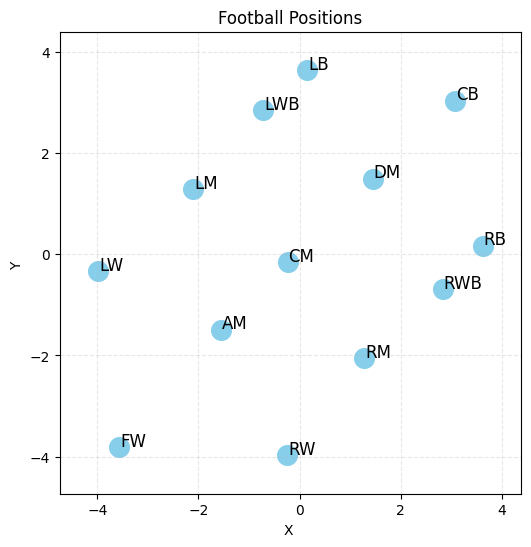

In [50]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

def positions_to_coords(dist_dict, n_dim=2, random_state=42):
    """
    将位置间距离规则映射成坐标。
    
    参数：
    - dist_dict: dict, 形如 {('ST','CF'):0.1, ('ST','CB'):1.0, ...}，表示已知距离
    - n_dim: int, 坐标维度
    - random_state: int, 随机种子
    
    返回：
    - pos_coords: dict, 位置->坐标 ndarray
    """
    # 1. 获取所有位置
    positions = sorted({p for pair in dist_dict.keys() for p in pair})
    n_pos = len(positions)
    pos_index = {p:i for i,p in enumerate(positions)}
    
    # 2. 构建完整距离矩阵（未知距离用较大值或平均值）
    dist_matrix = np.zeros((n_pos,n_pos))
    for i in range(n_pos):
        for j in range(n_pos):
            if i == j:
                dist_matrix[i,j] = 0
            else:
                key1 = (positions[i], positions[j])
                key2 = (positions[j], positions[i])
                if key1 in dist_dict:
                    dist_matrix[i,j] = dist_dict[key1]
                elif key2 in dist_dict:
                    dist_matrix[i,j] = dist_dict[key2]
                else:
                    dist_matrix[i,j] = 1.0  # 默认距离，可根据需要调整

    # 3. MDS映射
    mds = MDS(n_components=n_dim, dissimilarity='precomputed', random_state=random_state)
    coords = mds.fit_transform(dist_matrix)
    
    # 4. 输出字典
    pos_coords = {p: coords[pos_index[p]] for p in positions}
    return pos_coords

coords = positions_to_coords(distances, n_dim=2)
for k,v in coords.items():
    print(k, v)
# 提取所有 x, y
xs = [x for x, y in coords.values()]
ys = [y for x, y in coords.values()]

# 创建图
plt.figure(figsize=(8,6))
plt.title("Football Positions")
plt.xlabel("X ")
plt.ylabel("Y ")

# 画每个位置
for pos, (x, y) in coords.items():
    plt.scatter(x, y, s=200, c='skyblue')
    plt.text(x+0.02, y+0.02, pos, fontsize=12)

# 自动设置坐标范围并加边距
x_margin = (max(xs)-min(xs))*0.1
y_margin = (max(ys)-min(ys))*0.1
plt.xlim(min(xs)-x_margin, max(xs)+x_margin)
plt.ylim(min(ys)-y_margin, max(ys)+y_margin)

plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()


In [51]:
import math

# 对称化距离字典
sym_distances = {}
for (a,b), d in distances.items():
    sym_distances[(a,b)] = d
    sym_distances[(b,a)] = d
    sym_distances[(a,a)] = 0
    sym_distances[(b,b)] = 0

def weighted_posset_distance(setA, setB, weightsA, weightsB, default_distance=10):
    """
    计算两个球员位置集合的加权距离
    setA, setB: list of position
    weightsA, weightsB: dict，位置 -> 熟练比重
    """
    if not setA or not setB:
        return float('inf')
    
    total_dist = 0
    for a in setA:
        for b in setB:
            dist = sym_distances.get((a,b), default_distance)
            total_dist += dist * weightsA.get(a,0) * weightsB.get(b,0)
    return total_dist

def weighted_posset_similarity(setA, setB, weightsA, weightsB, alpha=0.5):
    d = weighted_posset_distance(setA, setB, weightsA, weightsB)
    return math.exp(-alpha*d)

# ------------------------------
# 示例
# ------------------------------
player1 = ['CB']
weights1 = {'CB':1}   # 熟练比重

player2 = ['CB','LB','RB']
weights2 = {'CB': 0.9719495091164095, 'LB': 0.02208976157082749, 'RB': 0.005960729312762973}

dist = weighted_posset_distance(player1, player2, weights1, weights2)
sim = weighted_posset_similarity(player1, player2, weights1, weights2)

print("加权集合距离:", dist)
print("加权集合相似度:", sim)


加权集合距离: 0.056100981767180924
加权集合相似度: 0.9723392712928622


In [52]:
import math

# coords 是位置到坐标的映射
# 示例：
# coords = {
#     "CB": (0.75, -0.68),
#     "LB": (-0.48, 0.13),
#     ...
# }

def split_WB_posset(weights, posset):
    """
    将 WB 拆分成 LWB/RWB，更新 weights 和 posset
    weights: dict, 位置 -> 权重（含 WB）
    posset: list, 位置集合（含 WB）
    返回: (new_weights, new_posset)
    """
    w_WB = weights.get('WB', 0)
    if w_WB == 0:
        return weights, posset  # 没有 WB，直接返回

    # 定义左右位置集合
    left_positions = ['LB','LM','LW']
    right_positions = ['RB','RM','RW']

    total_L = sum(weights.get(p,0) for p in left_positions)
    total_R = sum(weights.get(p,0) for p in right_positions)
    total = total_L + total_R

    if total == 0:
        ratio_L, ratio_R = 0.5, 0.5
    else:
        ratio_L = total_L / total
        ratio_R = total_R / total

    # 拆分 WB 权重
    w_LWB = w_WB * ratio_L
    w_RWB = w_WB * ratio_R

    # 更新 weights
    new_weights = weights.copy()
    new_weights.pop('WB')
    if w_LWB > 0:
        new_weights['LWB'] = w_LWB
    if w_RWB > 0:
        new_weights['RWB'] = w_RWB

    # 更新 posset
    new_posset = [p for p in posset if p != 'WB']
    if w_LWB > 0:
        new_posset.append('LWB')
    if w_RWB > 0:
        new_posset.append('RWB')

    return new_weights, new_posset



def player_weighted_coord(posset, weights, coords=coords):
    """
    计算球员加权坐标
    posset: list of 位置字符串
    weights: dict, 位置 -> 权重
    coords: dict, 位置 -> (x,y) 坐标
    """
    weights, posset = split_WB_posset(weights,posset)
    total_weight = sum(weights.get(p, 0) for p in posset)
    if total_weight == 0:
        return (0,0)
    
    x = sum(coords[p][0] * weights.get(p, 0) for p in posset) / total_weight
    y = sum(coords[p][1] * weights.get(p, 0) for p in posset) / total_weight
    return (x, y)

def weighted_coord_similarity(possetA, weightsA, possetB, weightsB, coords=coords, alpha=1.0):
    """
    基于加权坐标的欧氏距离计算相似度
    """
    x1, y1 = player_weighted_coord(possetA, weightsA, coords)
    x2, y2 = player_weighted_coord(possetB, weightsB, coords)
    dist = math.sqrt((x1-x2)**2 + (y1-y2)**2)
    return math.exp(-alpha*dist)

# ------------------------------
# 示例
# ------------------------------
player1_pos = ['CB']
player1_weights = {'CB': 1}

player2_pos = ['CB','LB','RB']
player2_weights = {'CB': 0.97, 'LB': 0.02, 'RB': 0.01}

sim = weighted_coord_similarity(player1_pos, player1_weights,
                                player2_pos, player2_weights,
                                coords, alpha=1.5)

print("基于加权坐标的相似度:", sim)


基于加权坐标的相似度: 0.9203365512608005


In [53]:
import pandas as pd
import itertools
import math

# -----------------------------
# 假设 sym_distances 已定义
# posset_distance_weighted 和 posset_similarity_weighted 已定义
# -----------------------------

# 读取 CSV
df = pd.read_csv("player_features.csv")
df['Pos_set'] = df['Pos_set'].astype(str)

# 示例球员列表
player_names = ["Bukayo Saka", "Jakub Kiwior", "Nicolas Jackson", 
                "Amadou Onana", "Ryan Gravenberch", "Mohamed Salah", "Virgil van Dijk"]

# 构建球员到 Pos_set 和 Pos_weights 的映射
player_possets = {}
player_posweights = {}
for _, row in df.iterrows():
    name = row['name']
    if name not in player_names:
        continue
    # Pos_set
    pos_list = row['Pos_set'].split(', ') if pd.notna(row['Pos_set']) else []
    player_possets[name] = pos_list
    # Pos_weights
    try:
        weights = eval(row['Pos_weights']) if pd.notna(row['Pos_weights']) else {}
    except:
        weights = {}
    player_posweights[name] = weights

# 保存相似度结果
similarities = []
similarities1 = []
# 两两组合计算加权相似度
for p1, p2 in itertools.combinations(player_names, 2):
    if p1 in player_possets and p2 in player_possets:
        set1 = player_possets[p1]
        set2 = player_possets[p2]
        weights1 = player_posweights.get(p1, None)
        if len(weights1) == 0:
            print(p1+" has no pos weight") 
            similarities.append((p1, p2, 0))
            continue
        weights2 = player_posweights.get(p2, None)
        if len(weights2) == 0:
            print(p2+" has no pos weight") 
            similarities.append((p1, p2, 0))
            continue

        sim1 = weighted_posset_similarity(set1, set2, weights1, weights2)
        sim = weighted_coord_similarity(set1, weights1,
                                set2, weights2)
        similarities.append((p1, p2, sim))
        similarities1.append((p1, p2, sim1))

# 按相似度从高到低排序
similarities_sorted = sorted(similarities, key=lambda x: x[2], reverse=True)
similarities_sorted1 = sorted(similarities1, key=lambda x: x[2], reverse=True)

# 输出结果
print("coord sim")
for p1, p2, sim in similarities_sorted:
    print(f"{p1} - {p2}: {sim:.4f}")
print("\nset sim")
for p1, p2, sim in similarities_sorted1:
    print(f"{p1} - {p2}: {sim:.4f}")


coord sim
Jakub Kiwior - Virgil van Dijk: 0.9406
Amadou Onana - Ryan Gravenberch: 0.8447
Bukayo Saka - Mohamed Salah: 0.4671
Jakub Kiwior - Ryan Gravenberch: 0.0753
Ryan Gravenberch - Virgil van Dijk: 0.0719
Jakub Kiwior - Amadou Onana: 0.0639
Amadou Onana - Virgil van Dijk: 0.0610
Nicolas Jackson - Mohamed Salah: 0.0455
Bukayo Saka - Nicolas Jackson: 0.0227
Bukayo Saka - Amadou Onana: 0.0141
Bukayo Saka - Ryan Gravenberch: 0.0125
Amadou Onana - Mohamed Salah: 0.0080
Ryan Gravenberch - Mohamed Salah: 0.0070
Bukayo Saka - Jakub Kiwior: 0.0012
Nicolas Jackson - Amadou Onana: 0.0012
Bukayo Saka - Virgil van Dijk: 0.0012
Nicolas Jackson - Ryan Gravenberch: 0.0010
Jakub Kiwior - Mohamed Salah: 0.0006
Mohamed Salah - Virgil van Dijk: 0.0006
Jakub Kiwior - Nicolas Jackson: 0.0001
Nicolas Jackson - Virgil van Dijk: 0.0001

set sim
Jakub Kiwior - Virgil van Dijk: 0.9723
Amadou Onana - Ryan Gravenberch: 0.7544
Bukayo Saka - Mohamed Salah: 0.4481
Nicolas Jackson - Mohamed Salah: 0.2943
Ryan Grave

# KMeans

In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import math

# ------------------------------
# 读取数据
# ------------------------------
df = pd.read_csv("player_features.csv")
# ------------------------------
# 列名分组
# ------------------------------

# 基础身体属性
physical_cols = [
    'height','weight','Footed'
]

# 防守指标
defense_cols = [
    'Tkl','TklW','Blocks','Int','Clr','Err','Tkl%','Tkl+Int','Def 3rd','Mid 3rd','Att 3rd'
]

# 进攻 / 传球指标
offense_cols = [
    'Sh','Pass','Att','Lost'
]

# 门将类指标（如果有）
gk_cols = [
    'SoTA','GA'
]

# 触球 / 控球指标（之前的也可以补进来）
possession_cols = [
    'Touches','Carries','PrgC','CPA','Mis','Dis','Rec','PrgR'
]

# 成功率
success_cols = ['Succ%','Tkld%']

other_cols = ['Pos_set','Pos_weights']

# 汇总
all_feature_cols = (
    physical_cols + defense_cols + offense_cols + 
    gk_cols + possession_cols + success_cols+other_cols
)

# 打印结果（便于直接复制）
print("聚类特征列:")
print(','.join(f"'{c}'" for c in all_feature_cols))


聚类特征列:
'height','weight','Footed','Tkl','TklW','Blocks','Int','Clr','Err','Tkl%','Tkl+Int','Def 3rd','Mid 3rd','Att 3rd','Sh','Pass','Att','Lost','SoTA','GA','Touches','Carries','PrgC','CPA','Mis','Dis','Rec','PrgR','Succ%','Tkld%','Pos_set','Pos_weights'


In [55]:

from sklearn.impute import KNNImputer, SimpleImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
posset_col = 'Pos_set'
# 预处理NaN
df[posset_col] = df[posset_col].astype(str)

# ------------------------------
# 忽略含GK的行
# ------------------------------
df_filtered = df[~df['Pos_set'].str.contains('GK')].copy()
df_filtered = df_filtered[~df_filtered['Pos_set'].str.contains('0')].copy()
footed_onehot = pd.get_dummies(df_filtered['Footed'], prefix='Footed')
df_filtered = pd.concat([df_filtered, footed_onehot], axis=1)

def parse_weights(weights_str):
    try:
        return eval(weights_str) if pd.notna(weights_str) else {}
    except:
        return {}

weighted_coords = np.array([
    player_weighted_coord(
        list(parse_weights(row['Pos_weights']).keys()),  # 用 weights 的 keys 作为 posset
        parse_weights(row['Pos_weights'])                # 权重字典
    )
    for _, row in df_filtered.iterrows()
])


# 数值列标准化
# 自动筛选数值列
numeric_cols = df_filtered.select_dtypes(include=np.number).columns.tolist()

# 提取数值矩阵
X_num = df_filtered[numeric_cols].values

# ① 先用 KNNImputer 填补空值
imputer = KNNImputer(n_neighbors=5, weights='distance')
X_num_imputed = imputer.fit_transform(X_num)

# ② 再标准化
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num_imputed)



# 特征矩阵
X = np.hstack([X_num_scaled, weighted_coords])

In [86]:
rule_groups = [
    ["Virgil van Dijk", "Ibrahima Konaté"],
    ["Trent Alexander-Arnold", "Conor Bradley", "Reece James"],
    ["Alexander Isak", "Erling Haaland"],
    ["Ryan Gravenberch","Moisés Caicedo","Enzo Fernández"],
    ["James Maddison","Dominik Szoboszlai"],
    ["Nicolas Jackson","Erling Haaland"],
    ["Jeremie Frimpong","Trent Alexander-Arnold", "Conor Bradley"],
    ["Rayan Aït-Nouri","Andrew Robertson"],
    ["Sandro Tonali","Declan Rice"],
    ["Mohamed Salah","Phil Foden"],
    ["Jack Grealish","Luis Díaz"],
    ["Brennan Johnson","Mohamed Salah"]
]

def evaluate_rules(df, labels, rule_groups):
    df_temp = df.copy()
    df_temp['cluster'] = labels
    satisfied = 0
    for group in rule_groups:
        # 获取每个球员所在簇
        clusters = df_temp[df_temp['name'].isin(group)]['cluster'].values
        # 如果所有簇都不重复 → 规则满足
        if len(clusters) == len(set(clusters)):
            satisfied += 1
    return satisfied / len(rule_groups)  # 返回比例

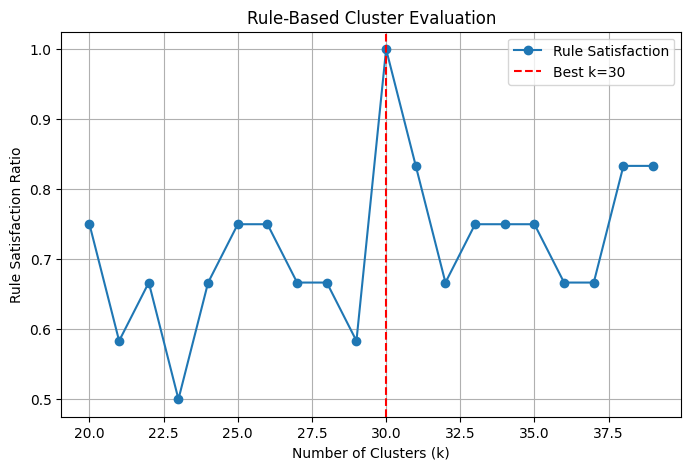

✅ 最优簇数: 30, 规则满足比例: 1.0000


In [87]:

# 循环不同簇数
cluster_range = range(20, 40)
rule_scores = []

best_score = -1
best_k = None
best_labels = None

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    score = evaluate_rules(df_filtered, labels, rule_groups)
    rule_scores.append(score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels

# 绘制规则满足比例随簇数变化图
plt.figure(figsize=(8,5))
plt.plot(list(cluster_range), rule_scores, marker='o', label='Rule Satisfaction')
plt.axvline(best_k, color='red', linestyle='--', label=f'Best k={best_k}')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Rule Satisfaction Ratio")
plt.title("Rule-Based Cluster Evaluation")
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ 最优簇数: {best_k}, 规则满足比例: {best_score:.4f}")

In [88]:
def violated_rules_with_clusters(df, labels, rule_groups):
    """返回违反规则的球员名字及其簇"""
    df_temp = df.copy()
    df_temp['cluster'] = labels
    violated_info = []
    
    for i, group in enumerate(rule_groups):
        # 获取组内球员簇
        clusters = df_temp[df_temp['name'].isin(group)][['name','cluster']]
        # 如果簇重复 → 规则被违反
        if len(clusters['cluster'].unique()) < len(clusters):
            violated_info.append((i, clusters))
    
    return violated_info

# 假设 best_labels 已经通过 KMeans 得到
violations = violated_rules_with_clusters(df_filtered, best_labels, rule_groups)

if len(violations) == 0:
    print("✅ 所有规则在最优簇数下都满足！")
else:
    print(f"⚠️ 最优簇数 {best_k} 下仍有 {len(violations)} 条规则未满足：\n")
    for idx, cluster_info in violations:
        print(f"规则 {idx}:")
        print(cluster_info.to_string(index=False))
        print("-" * 40)


✅ 所有规则在最优簇数下都满足！


In [90]:
# 聚类
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

df_filtered['cluster'] = labels

# 按 cluster 排序
df_filtered_sorted = df_filtered.sort_values(by='cluster').reset_index(drop=True)

# 保存文件
df_filtered_sorted.to_csv("player_features_clustered_noGK_sorted.csv", encoding="utf-8-sig", index=False)

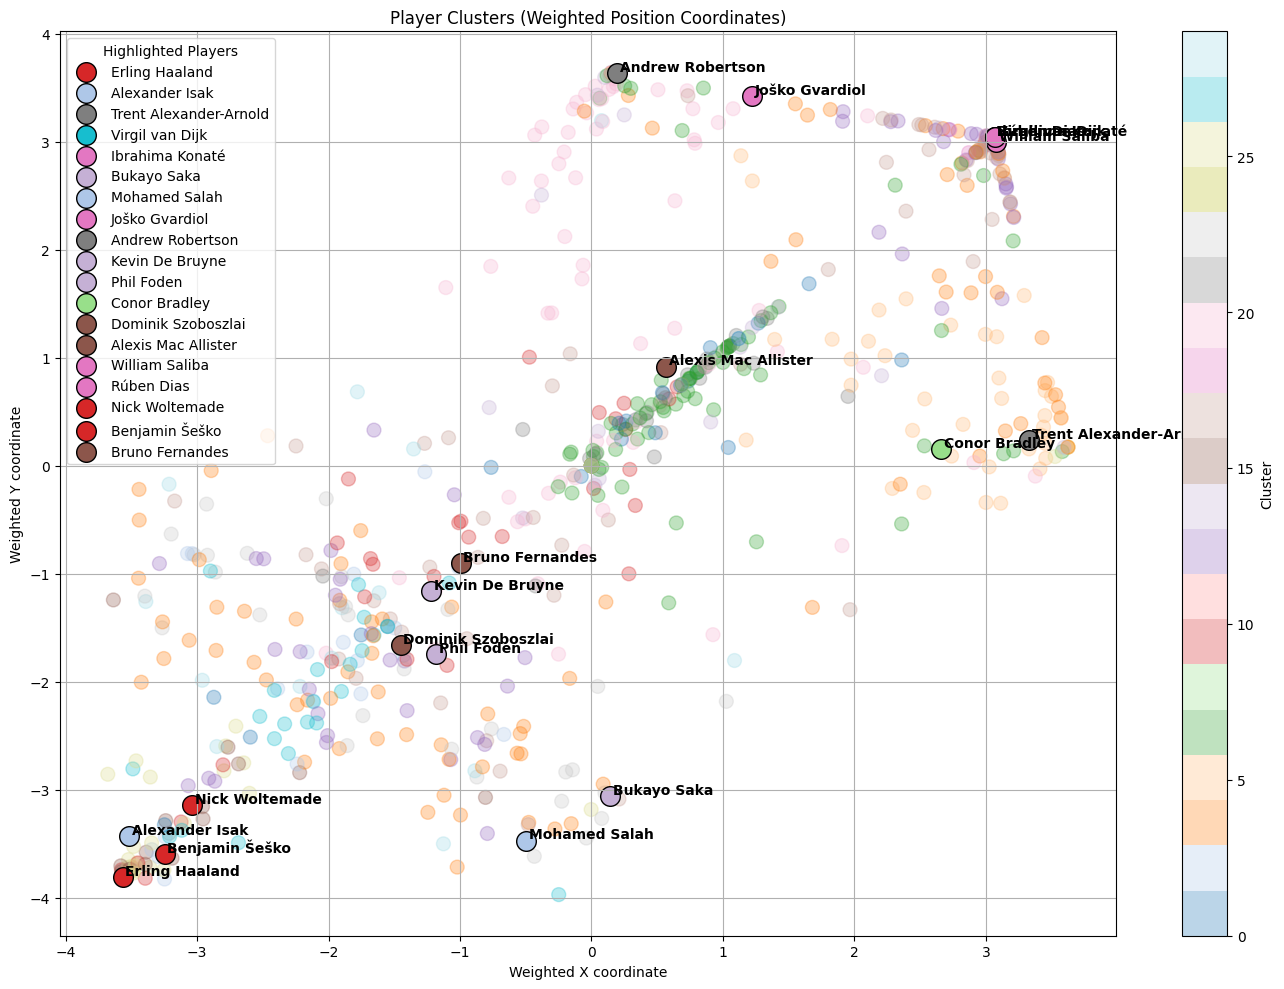

In [106]:
import matplotlib.pyplot as plt

# 假设 weighted_coords 已经是每个球员的加权坐标 (x, y)
# df_filtered['cluster'] 是聚类标签
x = weighted_coords[:, 0]
y = weighted_coords[:, 1]

# 你提供要高亮的球员名字列表
highlight_names = [
    "Erling Haaland", "Alexander Isak", "Trent Alexander-Arnold","Virgil van Dijk", 
    "Ibrahima Konaté", "Bukayo Saka", "Mohamed Salah", "Joško Gvardiol", "Andrew Robertson", 
    "Kevin De Bruyne", "Phil Foden", "Conor Bradley","Dominik Szoboszlai", "Alexis Mac Allister", 
    "William Saliba", "Rúben Dias","Nick Woltemade","Benjamin Šeško","Bruno Fernandes"]


plt.figure(figsize=(14, 10))

# 所有球员散点，半透明
scatter = plt.scatter(x, y, c=df_filtered['cluster'], cmap='tab20', s=100, alpha=0.3)

# 获取 colormap 对应 cluster 的颜色
cmap = plt.get_cmap('tab20')
clusters = df_filtered['cluster'].unique()
cluster_colors = {c: cmap(c % 20) for c in clusters}

# 用于高亮球员的 Legend handle 列表
highlight_handles = []

# 高亮球员
for name in highlight_names:
    mask = df_filtered['name'] == name
    if mask.sum() == 0:
        print(f"⚠️ {name} 不在数据中，已跳过")
        continue
    xi = x[mask][0]
    yi = y[mask][0]
    cluster_label = df_filtered.loc[mask, 'cluster'].values[0]
    
    # 高亮点
    sc = plt.scatter(xi, yi, s=200, color=cluster_colors[cluster_label], edgecolors='black')
    plt.text(xi + 0.02, yi + 0.02, name, fontsize=10, weight='bold')
    
    # 添加 Legend handle
    highlight_handles.append(sc)

# 添加高亮球员的单独 Legend
plt.legend(highlight_handles, [name for name in highlight_names if df_filtered['name'].isin([name]).any()],
           title="Highlighted Players", bbox_to_anchor=(0, 1), loc='upper left')

plt.xlabel('Weighted X coordinate')
plt.ylabel('Weighted Y coordinate')
plt.title('Player Clusters (Weighted Position Coordinates)')
plt.colorbar(scatter, label='Cluster')  # 保留 cluster 边栏
plt.grid(True)
plt.tight_layout()
plt.show()


In [107]:
import json

# 按 cluster 分组，并选取最多 10 个球员
clustered_sample = {}
for cluster_id, group in df_filtered.groupby('cluster'):
    sample = group.sample(n=min(5, len(group)), random_state=42)
    # 只保留你需要的信息，比如 name 和 Pos_set
    clustered_sample[cluster_id] = sample[['name', 'Pos_set']].to_dict(orient='records')

# 写入 JSON 文件
with open('clustered_sample.json', 'w', encoding='utf-8') as f:
    json.dump(clustered_sample, f, ensure_ascii=False, indent=4)

print("JSON 文件已生成：clustered_sample.json")


JSON 文件已生成：clustered_sample.json


# ratings


In [ ]:
import os
import json
import pandas as pd
from collections import defaultdict
from datetime import datetime
import re

# -------------------------------
# 配置路径
# -------------------------------
BASE_DIR = r"C:\Users\mhuiuyd\Desktop\RAW_TRACKS\National University of Singapore\Sandesh Sreepathy Upadhyaya - Football Dataset"
SEASON_FOLDERS = ["2526_FINAL"]
OUTPUT_CSV = "player_summary_all_seasons_latest5.csv"

TARGET_JSONS = [
    "defense_all.json",
    "keeper_all.json",
    "misc_all.json",
    "passing_all.json",
    "passing_types_all.json",
    "possession_all.json",
    "summary_all.json"
]


def safe_float_latest5(x):
    """安全转换为 float"""
    try:
        return float(x)
    except (ValueError, TypeError):
        return None


def clean_info_fields_latest5(info):
    """清洗 info.json 中的 height / weight 字段"""
    cleaned = dict(info)

    def is_invalid_height_or_weight(val: str) -> bool:
        if not isinstance(val, str):
            return False
        # 含有月份、字母、Age、括号的都判为异常
        if re.search(r"[A-Za-z]", val) or "(" in val or ")" in val:
            return True
        # 长度太短或太长也可能是异常
        if len(val) > 10:
            return True
        return False

    for key in ["height", "weight"]:
        val = cleaned.get(key)
        if val and is_invalid_height_or_weight(val):
            cleaned[key] = ""

    return cleaned


def process_player_folder_latest5(player_folder):
    """处理单个球员文件夹，只取每个json中按Date最新的5场"""
    info_path = os.path.join(player_folder, "info.json")
    if not os.path.exists(info_path):
        return None

    # 读取 info.json
    with open(info_path, "r", encoding="utf-8") as f:
        try:
            info = json.load(f)
        except Exception:
            return None

    # 清洗异常 height / weight
    info = clean_info_fields_latest5(info)

    player_name = info.get("name", None)
    if not player_name:
        return None

    numeric_max = {}
    match_num = 0
    pos_set = set()

    for file_name in TARGET_JSONS:
        file_path = os.path.join(player_folder, file_name)
        if not os.path.exists(file_path):
            continue

        # 读取文件
        with open(file_path, "r", encoding="utf-8") as f:
            try:
                data = json.load(f)
            except Exception:
                continue

        # ✅ 按 Date 排序，仅取最新5场
        valid_items = []
        for item in data:
            date_str = item.get("Date")
            try:
                item["_date"] = datetime.strptime(date_str, "%Y-%m-%d")
                valid_items.append(item)
            except Exception:
                continue

        if not valid_items:
            continue

        valid_items.sort(key=lambda x: x["_date"], reverse=True)
        recent_items = valid_items[:5]

        candidate_match_num = 0
        file_sums = defaultdict(float)

        for item in recent_items:
            min_val = safe_float_latest5(item.get("Min"))
            if min_val is None:
                continue
            candidate_match_num += 1

            for k, v in item.items():
                val = safe_float_latest5(v)
                if val is not None:
                    file_sums[k] += val

            pos_val = item.get("Pos", "")
            if pos_val and pos_val != "On matchday squad, but did not play":
                for p in pos_val.replace(" ", "").split(","):
                    if p:
                        pos_set.add(p)

        # 不同文件间取最大值
        for k, v in file_sums.items():
            if k in numeric_max:
                numeric_max[k] = max(numeric_max[k], v)
            else:
                numeric_max[k] = v

        match_num = max(match_num, candidate_match_num)

    numeric_max["Pos_set"] = ", ".join(sorted(pos_set))
    numeric_max["Match_num"] = match_num

    return {**info, **numeric_max}


def aggregate_all_players_latest5():
    """跨赛季汇总，仅取每名球员最新5场"""
    all_players = defaultdict(lambda: defaultdict(list))
    all_positions = defaultdict(set)
    base_info = {}

    for season in SEASON_FOLDERS:
        season_path = os.path.join(BASE_DIR, season)
        if not os.path.exists(season_path):
            print(f"⚠️ 跳过不存在的目录: {season_path}")
            continue

        for club in os.listdir(season_path):
            club_path = os.path.join(season_path, club)
            if not os.path.isdir(club_path):
                continue

            for player in os.listdir(club_path):
                player_folder = os.path.join(club_path, player)
                if not os.path.isdir(player_folder):
                    continue

                result = process_player_folder_latest5(player_folder)
                if not result:
                    continue

                name = result.get("name")
                base_info[name] = {k: result[k] for k in ["name", "height", "weight", "Footed"] if k in result}

                # 聚合数值
                for k, v in result.items():
                    if isinstance(v, (int, float)):
                        all_players[name][k].append(v)

                # 聚合位置
                if "Pos_set" in result and result["Pos_set"]:
                    all_positions[name].update(result["Pos_set"].split(", "))

    # 汇总平均
    summary_rows = []
    for name in all_players:
        info = base_info.get(name, {})
        avg_dict = {k: sum(vs) for k, vs in all_players[name].items()}
        avg_dict["Pos_set"] = ", ".join(sorted(all_positions[name]))
        summary_rows.append({**info, **avg_dict})

    df = pd.DataFrame(summary_rows)
    df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")
    print(f"✅ 已生成跨赛季球员数据汇总 (仅取最近5场): {OUTPUT_CSV}")
    print(f"📊 共 {len(df)} 名球员")


if __name__ == "__main__":
    aggregate_all_players_latest5()


✅ 已生成跨赛季球员数据汇总 (仅取最近5场): player_summary_all_seasons_latest5.csv
📊 共 523 名球员


In [ ]:
import pandas as pd
import numpy as np

# 读取 CSV 文件
df = pd.read_csv("player_summary_all_seasons_latest5.csv")

# 保留原样的字段
keep_cols = ["name", "height", "weight", "Footed", "Pos_set", "Match_num", "Min",'Pos_weights']

# 找到带%和非带%的数值列
percent_cols = [c for c in df.columns if "%" in c and c not in keep_cols]
numeric_cols = [c for c in df.columns if c not in keep_cols + percent_cols]

# 避免除0，先替换 Min 和 Match_num 为 1 的临时值
df["Min_temp"] = df["Min"].replace(0, 1)
df["Match_num_temp"] = df["Match_num"].replace(0, 1)

# 带%列除以 Match_num
for col in percent_cols:
    df[col] = df[col] / df["Match_num_temp"]

# 其他数值列除以 Min
for col in numeric_cols:
    df[col] = df[col] / df["Min_temp"]

# 删除临时列
df = df.drop(columns=["Min_temp", "Match_num_temp"])

# 保存
df.to_csv("player_features_latest5.csv", index=False, encoding="utf-8-sig")

